In [18]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

standard_flag = False

train_xlsx = '训练集3-1.xlsx'
test_xlsx = '验证集3.xlsx'

# 读取数据

In [19]:
df = pd.read_excel(train_xlsx, header=None)
df

,0,1,2,3,4,5,6,7,8
0,1.17362,1.581690,0.79089,1.23740,0.819020,1.228070,0.921780,1.405650,0
1,1.01716,1.395400,0.82012,1.35819,0.692390,1.115450,0.671460,1.032660,0
2,0.87372,1.318870,0.71429,1.16374,0.986350,1.425120,0.926260,1.304080,0
3,0.90368,1.314130,0.67532,1.25862,0.685480,1.124670,0.852420,1.236510,0
4,0.90515,1.403777,0.94649,1.45071,0.877157,1.328043,0.889893,1.335087,0
...,...,...,...,...,...,...,...,...,...
106,4.23711,10.399287,4.08486,13.43763,4.466397,13.563123,4.596263,11.756757,9
107,4.23941,10.397587,4.08625,13.42993,4.471537,13.572823,4.600393,11.754357,9
108,4.23948,10.395887,4.08107,13.44233,4.472417,13.567323,4.600533,11.738857,9
109,3.10690,7.583840,2.41300,8.54446,3.822900,10.860570,3.779900,9.829480,9


In [20]:
train_data = df.iloc[:, :8].values  # 前八列
train_labels = df.iloc[:, 8].values  # 第九列

inputs = train_data.astype(np.float32)
outputs = train_labels.astype(np.int64)
train_inputs_tensor = torch.from_numpy(inputs)
train_outputs_tensor = torch.from_numpy(outputs)

In [21]:
train_inputs_tensor

tensor([[ 1.1736e+00,  1.5817e+00,  7.9089e-01,  1.2374e+00,  8.1902e-01,
          1.2281e+00,  9.2178e-01,  1.4057e+00],
        [ 1.0172e+00,  1.3954e+00,  8.2012e-01,  1.3582e+00,  6.9239e-01,
          1.1155e+00,  6.7146e-01,  1.0327e+00],
        [ 8.7372e-01,  1.3189e+00,  7.1429e-01,  1.1637e+00,  9.8635e-01,
          1.4251e+00,  9.2626e-01,  1.3041e+00],
        [ 9.0368e-01,  1.3141e+00,  6.7532e-01,  1.2586e+00,  6.8548e-01,
          1.1247e+00,  8.5242e-01,  1.2365e+00],
        [ 9.0515e-01,  1.4038e+00,  9.4649e-01,  1.4507e+00,  8.7716e-01,
          1.3280e+00,  8.8989e-01,  1.3351e+00],
        [ 9.0764e-01,  1.4031e+00,  9.4463e-01,  1.4530e+00,  8.7828e-01,
          1.3295e+00,  8.8635e-01,  1.3357e+00],
        [ 9.0950e-01,  1.4162e+00,  9.4507e-01,  1.4518e+00,  8.7691e-01,
          1.3309e+00,  8.8689e-01,  1.3362e+00],
        [ 9.0905e-01,  1.4236e+00,  9.4677e-01,  1.4821e+00,  8.8285e-01,
          1.3302e+00,  8.8853e-01,  1.3358e+00],
        [ 9.1287

In [30]:
train_inputs_tensor.shape

torch.Size([111, 8])

In [22]:
train_outputs_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

# 训练

In [31]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 初始化模型
input_size = 8
hidden_size = 64
num_layers = 2
num_classes = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_history = []

num_epochs = 1000
batch_size = 32
for epoch in range(num_epochs):
    for i in range(0, len(train_inputs_tensor), batch_size):
        inputs = train_inputs_tensor[i:i+batch_size].unsqueeze(1)
        labels = train_outputs_tensor[i:i+batch_size]

        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_history.append(loss.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch 1/1000, Loss: 2.3335
Epoch 2/1000, Loss: 2.3146
Epoch 3/1000, Loss: 2.2939
Epoch 4/1000, Loss: 2.2706
Epoch 5/1000, Loss: 2.2429
Epoch 6/1000, Loss: 2.2086
Epoch 7/1000, Loss: 2.1653
Epoch 8/1000, Loss: 2.1101
Epoch 9/1000, Loss: 2.0404
Epoch 10/1000, Loss: 1.9534
Epoch 11/1000, Loss: 1.8473
Epoch 12/1000, Loss: 1.7223
Epoch 13/1000, Loss: 1.5816
Epoch 14/1000, Loss: 1.4316
Epoch 15/1000, Loss: 1.2816
Epoch 16/1000, Loss: 1.1416
Epoch 17/1000, Loss: 1.0198
Epoch 18/1000, Loss: 0.9207
Epoch 19/1000, Loss: 0.8444
Epoch 20/1000, Loss: 0.7882
Epoch 21/1000, Loss: 0.7478
Epoch 22/1000, Loss: 0.7191
Epoch 23/1000, Loss: 0.6987
Epoch 24/1000, Loss: 0.6837
Epoch 25/1000, Loss: 0.6723
Epoch 26/1000, Loss: 0.6630
Epoch 27/1000, Loss: 0.6549
Epoch 28/1000, Loss: 0.6475
Epoch 29/1000, Loss: 0.6408
Epoch 30/1000, Loss: 0.6346
Epoch 31/1000, Loss: 0.6291
Epoch 32/1000, Loss: 0.6242
Epoch 33/1000, Loss: 0.6199
Epoch 34/1000, Loss: 0.6161
Epoch 35/1000, Loss: 0.6128
Epoch 36/1000, Loss: 0.6096
E

In [34]:
for i in loss_history:
    print(i)

2.3334591388702393
2.3145551681518555
2.293877363204956
2.2705883979797363
2.2428929805755615
2.208606719970703
2.1652586460113525
2.1101434230804443
2.040412425994873
1.95339035987854
1.8473085165023804
1.7223353385925293
1.5815908908843994
1.4315869808197021
1.2815642356872559
1.1415530443191528
1.019787073135376
0.9206873774528503
0.8444433212280273
0.7881923913955688
0.7477810382843018
0.7190936207771301
0.6986528038978577
0.6837361454963684
0.6723185777664185
0.662990152835846
0.6548738479614258
0.6475241184234619
0.640785276889801
0.6346441507339478
0.6291248202323914
0.6242320537567139
0.6199301481246948
0.6161410808563232
0.6127511262893677
0.6096201539039612
0.606597900390625
0.6035479307174683
0.6003682017326355
0.5970078706741333
0.5934661626815796
0.5897740721702576
0.5859687328338623
0.5820733308792114
0.5780868530273438
0.5739908814430237
0.5697657465934753
0.5654056668281555
0.5609272122383118
0.5563676953315735
0.5517711639404297
0.5471702814102173
0.5425757765769958
0.

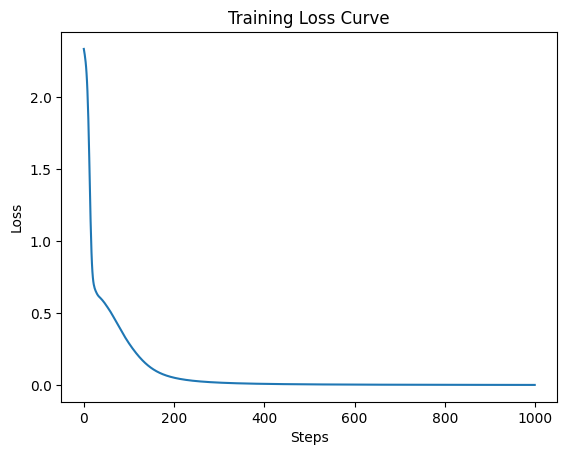

In [35]:
plt.plot(loss_history)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

# 保存和加载模型

In [36]:
torch.save(model.state_dict(), 'lstm.params')

# 测试

In [43]:
data_test = pd.read_excel(test_xlsx, header=None)
test_x = np.array(data_test.iloc[:, 0:8])
test_y = np.array(data_test.iloc[:, 8])
test_data = test_x.astype(np.float32)
test_labels = test_y.astype(np.int64)

test_inputs_tensor = torch.from_numpy(test_data)
test_outputs_tensor = torch.from_numpy(test_labels)

# 评估模式
clone = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
clone.load_state_dict(torch.load('lstm.params'))
clone.eval()

sum = 0
with torch.no_grad():
    test_inputs_tensor = test_inputs_tensor.unsqueeze(1).to(device)
    test_outputs_tensor = model(test_inputs_tensor)
    _, predicted = torch.max(test_outputs_tensor.data, 1)

    for i in range(len(test_data)):
        print(f"Predicted: {predicted[i]}, Actual: {test_labels[i]}")
        if predicted[i]==test_labels[i]:
            sum = sum+1

    accuracy = sum / len(test_data)
    print(f"Accuracy: {accuracy * 100}%")

Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Ac

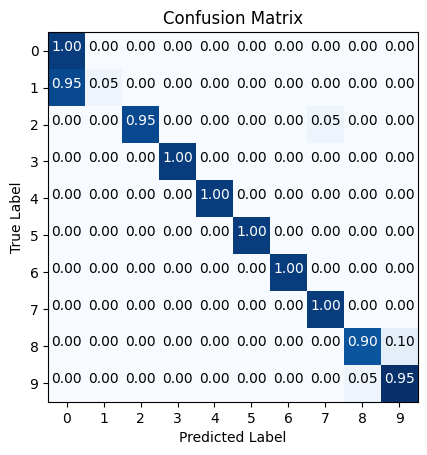

In [44]:
from sklearn.metrics import confusion_matrix
from matplotlib.colors import Normalize

cm = confusion_matrix(test_labels, predicted)

plt.imshow(cm, cmap='Blues', norm=Normalize(vmin=0, vmax=np.max(cm)))
# plt.colorbar()

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0

# 将混淆矩阵中的每个元素转换为保留两位小数的百分比形式
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm_percentage[i, j], '.2f'),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [45]:
import numpy as np
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

# 计算分类报告
report = classification_report(test_labels, predicted)

# 将报告中每个类别的指标保留小数点后四位
lines = report.split('\n')
new_report = []
for line in lines:
    if line.startswith('weighted avg'):
        items = line.split()
        new_line = '  '.join(items[:2])
        for item in items[2:]:
            if item.isnumeric():
                new_line += f'  {item}'
            else:
                new_line += f'  {float(item):.4f}'
        new_report.append(new_line)
    elif len(line.split()) > 0 and line.split()[0].isdigit():
        items = line.split()
        new_line = '  '.join(items[:2])
        for item in items[2:]:
            new_line += f'  {float(item):.4f}'
        new_report.append(new_line)
    else:
        new_report.append(line)

formatted_report = '\n'.join(new_report)
print(formatted_report)


              precision    recall  f1-score   support

0  0.51  1.0000  0.6800  20.0000
1  1.00  0.0500  0.1000  20.0000
2  1.00  0.9500  0.9700  20.0000
3  1.00  1.0000  1.0000  20.0000
4  1.00  1.0000  1.0000  20.0000
5  1.00  1.0000  1.0000  20.0000
6  1.00  1.0000  1.0000  20.0000
7  0.95  1.0000  0.9800  20.0000
8  0.95  0.9000  0.9200  20.0000
9  0.91  0.9500  0.9300  22.0000

    accuracy                           0.89       202
   macro avg       0.93      0.89      0.86       202
weighted  avg  0.9300  0.8900  0.8600  202



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# 计算预测结果的精确度和召回率
precision, recall, _ = precision_recall_curve(test_labels, predicted)

# 计算PR曲线下的面积
auc_score = auc(recall, precision)

# 绘制PR曲线
plt.plot(recall, precision, label='PR Curve (AUC = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve')
plt.show()
